---
title: Inference in Sinusoid Models
---

Consider the following dataset simulated using the model: 
\begin{equation*}
    y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin( 2 \pi f t) + \epsilon_t,
\end{equation*}
for $t = 1, \dots, n$ with some fixed values of $f, \beta_0, \beta_1, \beta_2$ and $\sigma$. The goal of this problem is to estimate $f$ along with associated uncertainty quantification.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
f = 0.2035
n = 400
b0 = 0
b1 = 3
b2 = 5
sig = 10
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc=0, scale = sig, size = n)
t = np.arange(1, n+1)
y = b0 * np.ones(n) + b1 * np.cos(2 * np.pi * f * t) + b2 * np.sin(2 * np.pi * f * t) + errorsamples

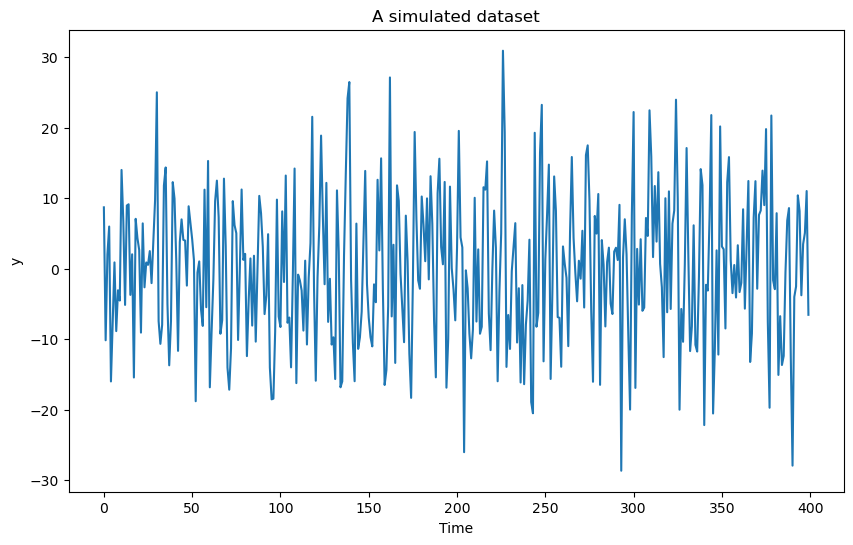

In [5]:
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('A simulated dataset')
plt.show()

To obtain the parameter estimates, we first obtain the estimate of $f$ (by minimizing RSS), then plug in $f = \hat{f}$, and run linear  regression to estimate the other parameters. 

In [6]:
def rss(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

0.2035520355203552


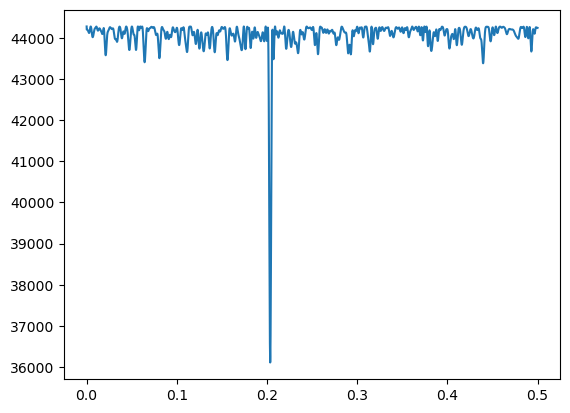

In [7]:
#We can minimize rss(f) over a fine grid of possible f values. Since n is not very big here, we can work with a dense grid. 
ngrid = 100000
allfvals = np.linspace(0, 0.5, ngrid)
rssvals = np.array([rss(f) for f in allfvals])
fhat = allfvals[np.argmin(rssvals)]
print(fhat)
plt.plot(allfvals, rssvals)
plt.show()

Compare the estimate $\hat{f}$ with the true value of $f$ which generated the data. 

After obtaining $\hat{f}$, we can do linear regression (where $f$ is fixed at $\hat{f}$) to compute the MLEs of the coefficient parameters and  $\sigma$. 



In [8]:
x = np.arange(1, n+1)
xcos = np.cos(2 * np.pi * fhat * x)
xsin = np.sin(2 * np.pi * fhat * x)
Xfhat = np.column_stack([np.ones(n), xcos, xsin])
md = sm.OLS(y, Xfhat).fit()
print(md.params) #this gives estimates of beta_0, beta_1, beta_2 (compare them to the true values which generated the data)
b0_est = md.params[0]
b1_est = md.params[1]
b2_est = md.params[2]
print(np.column_stack((np.array([b0_est, b1_est, b2_est]), np.array([b0, b1, b2]))))
rss_fhat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_fhat/n)
sigma_unbiased = np.sqrt((rss_fhat)/(n-3))
print(np.array([sigma_mle, sigma_unbiased, sig])) #sig is the true value of sigma which generated the data

[-0.05332889  3.00407151  5.63909328]
[[-0.05332889  0.        ]
 [ 3.00407151  3.        ]
 [ 5.63909328  5.        ]]
[ 9.50176964  9.53760297 10.        ]


Now let us use Bayesian inference for uncertainty quantification.  The Bayesian posterior for $f$ is:
\begin{equation*}
   I\{0 \leq f \leq 1/2\} |X_f^T X_f|^{-1/2} \left(\frac{1}{RSS(f)} \right)^{(n-p)/2}
\end{equation*}
where $p = 3$ and $|X_f^T X_f|$ denotes the determinant of $X_f^T X_f$. 

It is better to compute the logarithm of the posterior (as opposed to the posterior directly) because of numerical issues. 

In [13]:
def logpost(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

While evaluating the log posterior on a grid, it is important to make sure that we do not include frequencies $f$ for which $X_f^T X_f$ is singular. This will be the case for $f = 0$ and $f = 1/2$. When $f$ is very close to 0 or $0.5$, the term $|X_f^T X_f|^{-1/2}$ will be very large because of near-singularity of $X_f^T X_f$. We will therefore exclude frequencies very close to 0 and 0.5 from the grid while calculating posterior probabilities.  

From the Periodogram plotted above, it is clear that the maximizing frequency is around 0.2. So we will take a grid that around 0.2 (such as 0.05 to 0.35)

0.05 0.35


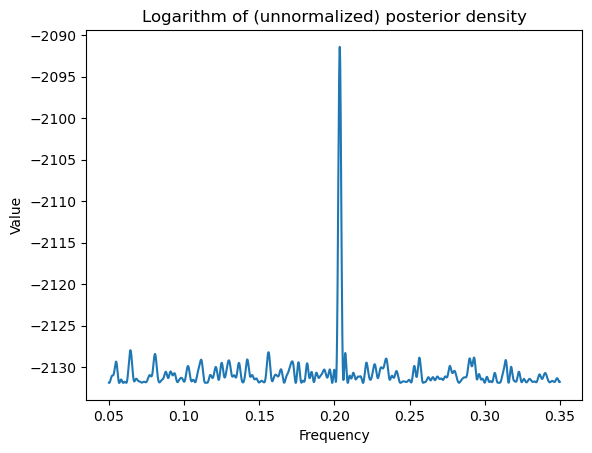

In [14]:
ngrid = 10000
allfvals = np.linspace(0.05, 0.35, ngrid)
print(np.min(allfvals), np.max(allfvals))
logpostvals = np.array([logpost(f) for f in allfvals])
plt.plot(allfvals, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show()

Note that the Logarithm of the posterior looks similar to the periodogram. But the posterior itself looks will have only one peak (which dominates all other peaks).

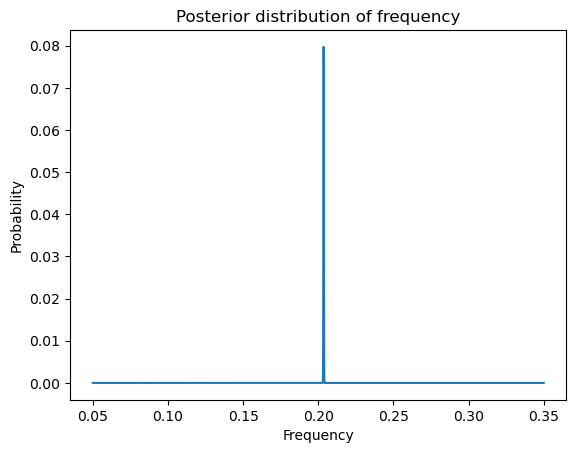

In [15]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))
plt.plot(allfvals, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

Using the posterior distribution, we can calculate posterior mean etc. and obtain credible intervals for $f$.

In [20]:
#Posterior mean of f:
fpostmean = np.sum(postvals * allfvals)
#Posterior mode of f:
fpostmode = allfvals[np.argmax(postvals)]
print(fpostmean, fpostmode, fhat)

0.2035529220195366 0.20355535553555354 0.2035520355203552


Note that the posterior mode is very close to least squares estimator. Let us now compute a credible interval for $f$. A 95\% credible interval is an interval for which the posterior probability is about 95\%. The following function takes an input value $m$ and compute the posterior probability assigned to the interval $\hat{f} - m*\delta, \hat{f} + m*\delta$ where $\delta$ is the grid resolution that we used for computing the posterior. 

We now start with a small value of $m$ (say $m = 0$) and keep increasing it until the posterior probability reaches 0.95. 

In [21]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)

In [22]:
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
print(m)

10


The credible interval for $f$ can then be computed in the following way.

In [23]:
est_ind = np.argmax(postvals)
f_est = allfvals[est_ind]
#95% credible interval for f:
ci_f_low = allfvals[est_ind - m]
ci_f_high = allfvals[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

[0.20355536 0.20325533 0.20385539]


We can draw posterior samples from f as follows. 

In [16]:
N = 2000
fpostsamples = rng.choice(allfvals, N, replace = True, p = postvals)

Given a posterior sample of $f$, a posterior sample of $\sigma$ can be drawn (this result was proved in Problem 5 of Homework one):
\begin{equation*}
   \frac{RSS(f)}{\sigma^2} \mid \text{data}, f \sim \chi^2_{n-3}
\end{equation*}
Further, given posterior samples from $f$ and $\sigma$, a posterior sample from $\beta = (\beta_0, \beta_1, \beta_2)$ is drawn using: 
\begin{equation*}
   \beta \mid \text{data}, \sigma, f \sim N_3 \left(\hat{\beta}_f, \sigma^2 (X_f^T X_f)^{-1} \right)
\end{equation*}
This is done in code as follows. 

In [17]:
post_samples = np.zeros(shape = (N, 5))
post_samples[:,0] = fpostsamples
for i in range(N):
    f = fpostsamples[i]
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md_f = sm.OLS(y, X).fit()
    chirv = rng.chisquare(df = n-p)
    sig_sample = np.sqrt(np.sum(md_f.resid ** 2)/chirv) #posterior sample from sigma
    post_samples[i, (p+1)] = sig_sample
    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_f.params, cov = covmat, size = 1)
    post_samples[i, 1:(p+1)] = beta_sample
print(post_samples)

[[ 0.20340534 -0.56189444  3.28165364  5.35964685  9.18963362]
 [ 0.20367537 -1.22669044  3.16545782  6.3549404   9.63517389]
 [ 0.20343534 -0.18052831  3.81020787  5.08243908  9.38448971]
 ...
 [ 0.20355536 -0.24135565  2.17378505  5.44757671  9.50053706]
 [ 0.20355536 -0.37830076  2.90179999  6.50300091  9.49852951]
 [ 0.20337534 -0.52307159  4.11483084  4.68294379  9.84908592]]


Let us plot the posterior functions along with the original data to visualize uncertainty. 

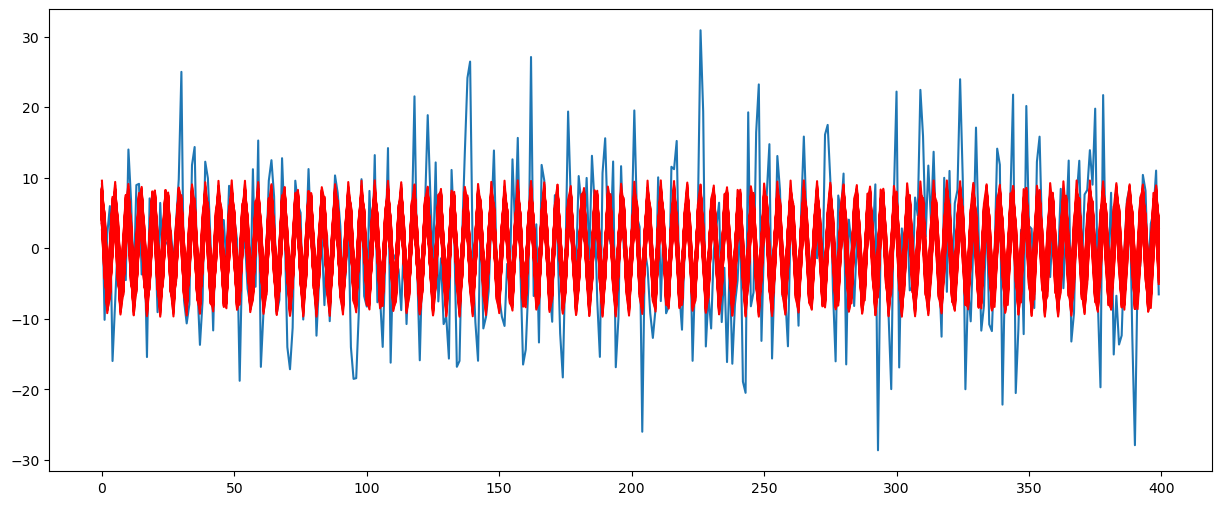

In [18]:
x = np.arange(1, n+1)
plt.figure(figsize = (15, 6))
plt.plot(y)
for i in range(N):
    f = fpostsamples[i]
    b0 = post_samples[i, 1]
    b1 = post_samples[i, 2]
    b2 = post_samples[i, 3]
    ftdval = b0 + b1 * np.cos(2 * np.pi * f * x) + b2 * np.sin(2 * np.pi * f * x)
    plt.plot(ftdval, color = 'red')

A simple summary of the posterior samples can be obtained as follows. 

In [19]:
pd.DataFrame(post_samples).describe()
#note that the true value of f is 0.2035, b0 is 0, b1 is 3, b2 is 5 and sigma is 10

,0,1,2,3,4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.203554,-0.048116,2.926668,5.487344,9.567343
std,0.000154,0.479084,1.240482,0.894120,0.337935
min,0.203045,-2.282401,-1.430247,1.670873,8.564508
25%,0.203435,-0.359168,2.134556,4.928442,9.343711
50%,0.203555,-0.061192,3.009265,5.519098,9.567323
75%,0.203645,0.268955,3.769393,6.097100,9.787657
max,0.204095,1.614744,6.128241,8.477974,10.710101


## Frequency Aliasing

Now consider the same simulation setting as the previous problem but change the true frequency to $f = 2 - 0.2035$ as opposed to $f = 0.2035$. The analysis then would still yield an estimate which is close to 0.2035. This is because the frequency $f_0 = 0.2035$ is an alias of $f = 2 - 0.2035$ in the sense that the two sinusoids $s_t = R \cos (2 \pi f t + \phi)$ and $s_t = R \cos (2 \pi f_0 t - \phi)$ are identical when $t$ is integer-valued. One can note that the estimate of $\beta_2$ will have a flipped sign however. 

It is very important to note that aliasing is a consequence of our time variable taking the equally spaced values $1, \dots, n$. If we change the time variable to some non-uniform values (i.e., if we sample the sinusoid at a non-uniform set of values), then it is possible to estimate frequencies which are outside of the range $[0, 0.5]$. This is illustrated below with $f = 1.8$. We take time to be randomly chosen points in the range $[1, n]$. 

In [24]:
f = 2 - 0.2035
n = 400
b0 = 0
b1 = 3
b2 = 5
sig = 10
rng = np.random.default_rng()
errorsamples = rng.normal(loc=0, scale = sig, size = n)
#t = np.arange(1, n+1)
t = np.sort(rng.uniform(low = 1, high = n, size = n))
y = b0 * np.ones(n) + b1 * np.cos(2 * np.pi * f * t) + b2 * np.sin(2 * np.pi * f * t) + errorsamples

In [25]:
print(t) #time again ranges roughly between 1 and 400 but this time the values are not equally spaced

[  1.14975602   1.2120058    1.74037229   2.93828141   2.99555488
   3.22544303   3.42684266   3.46440704   3.84792778   4.12969
   4.40549321   5.92805797   7.30139115   8.56396777   9.27155691
   9.30912776   9.94332563  10.62717676  10.70331524  11.5338629
  12.89644896  14.38579427  15.17741209  15.8571532   18.97148464
  19.02467279  21.55042309  22.91270338  23.96687953  26.25990635
  26.65910504  26.78859856  26.92745295  27.01809884  28.07972662
  28.47621567  30.54669751  30.61933994  30.92850461  33.39876022
  34.82075941  37.41575987  37.64827907  38.09008891  38.51396405
  39.49557342  42.22266621  44.08835013  44.83343818  46.10338995
  47.49012765  47.49287564  47.92921263  48.3728239   50.73947705
  51.85128768  52.18202989  52.99353689  54.65041079  55.87703368
  56.38086113  56.63094771  58.37701761  59.81095746  60.93499155
  63.10985177  63.2705136   63.45129725  64.88098453  65.18193867
  66.19633902  66.74122819  67.77920012  67.80761924  68.11184098
  70.88549113 

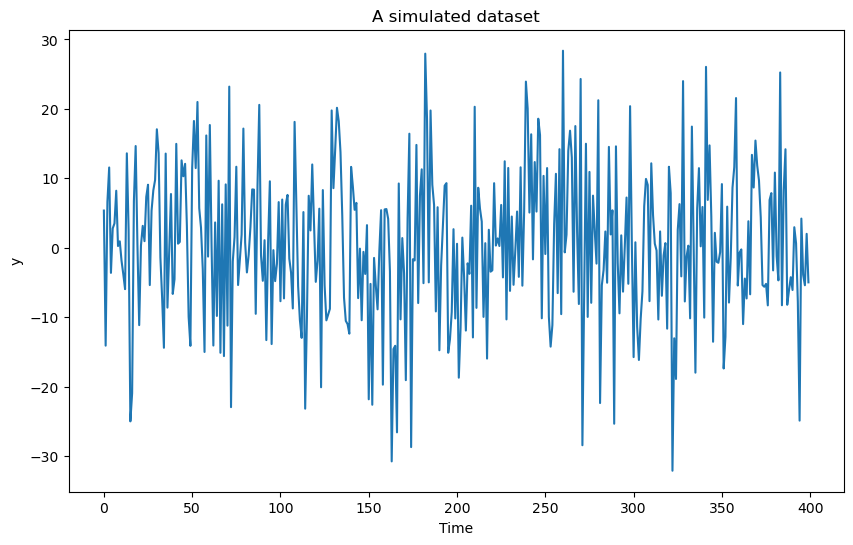

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('A simulated dataset')
plt.show()

We will again use RSS-minimization to estimate $f$. 

In [28]:
def rss(f):
    xcos = np.cos(2 * np.pi * f * t)
    xsin = np.sin(2 * np.pi * f * t)
    X = np.column_stack([np.ones(n), xcos, xsin])
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

To evaluate the criterion function, we shall take the grid to be spaced over the larger range $[0, 10]$. Note that we cannot restrict the frequency parameter to $[0, 1/2]$ because time is not equally spaced. 

In [29]:
ngrid = 100000
allfvals = np.linspace(0, 10, ngrid)
rssvals = np.array([rss(f) for f in allfvals])

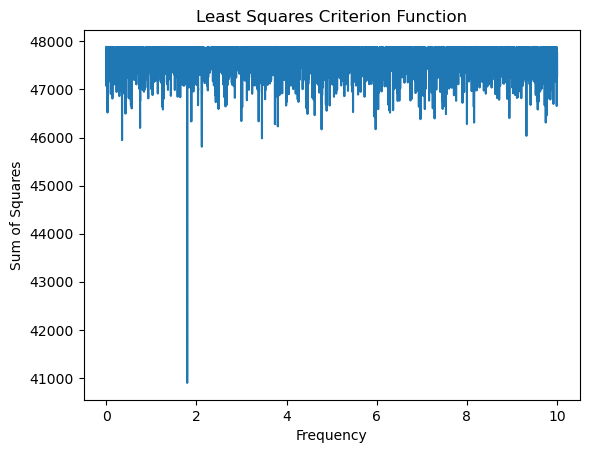

In [30]:
plt.plot(allfvals, rssvals)
plt.xlabel('Frequency')
plt.ylabel('Sum of Squares')
plt.title('Least Squares Criterion Function')
plt.show()

In [31]:
#the least squares estimate of f is now:
fhat = allfvals[np.argmin(rssvals)]
print(fhat)

1.796517965179652


This $\hat{f}$ is very close to $2 - 0.2035$. The Bayesian analysis will also give a posterior that is tightly concentrated around $(2 - 0.2035)$.

In [32]:
def logpost(f):
    xcos = np.cos(2 * np.pi * f * t)
    xsin = np.sin(2 * np.pi * f * t)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

0.01000010000100001 10.0


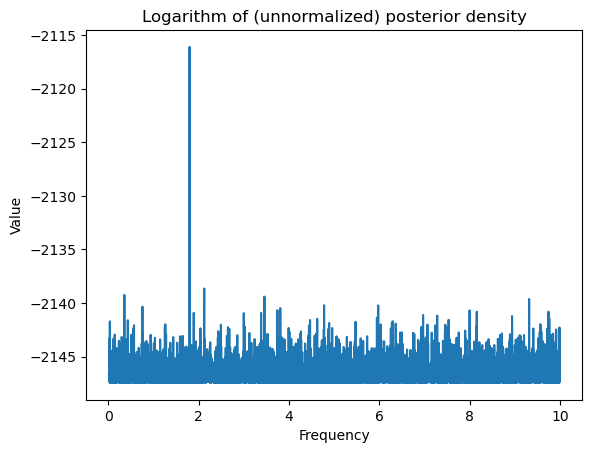

In [33]:
allfvals = allfvals[100:ngrid] #we are removing some values near 0 to prevent singularity of X_f^T X_f
print(np.min(allfvals), np.max(allfvals))
logpostvals = np.array([logpost(f) for f in allfvals])
plt.plot(allfvals, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show()

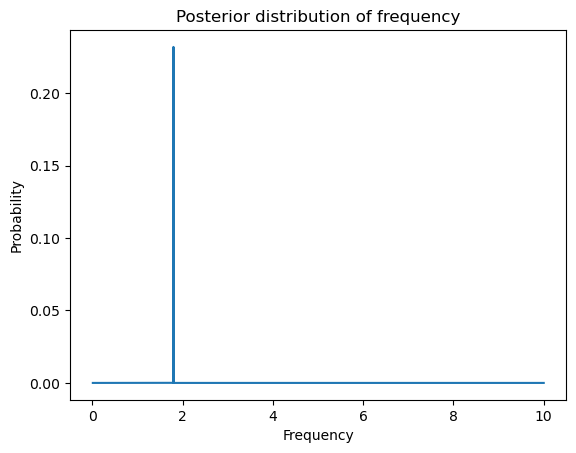

In [34]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))
plt.plot(allfvals, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

In [35]:
#Posterior mean of f:
fpostmean = np.sum(postvals * allfvals)
#Posterior mode of f:
fpostmode = allfvals[np.argmax(postvals)]
print(fpostmean, fpostmode, fhat)

1.7965379811361581 1.796517965179652 1.796517965179652
